Data Portraits of Industry in America
==============

This program uses public data to display information about industry in the continental U.S.
- It was developed as the final project for IST 652: Scripting for Data Analysis taught by Dr. Gregory Block
- Data sources include:
   - U.S. Bureau of Labor Statistics API
   - Standard & Poor's 500 
   - Morgan Stanley Capital International
   - U.S. Census Bureau

In [1]:
# Import dependencies

In [2]:
import os
# start off in the right directory
os.chdir('/Users/jill/Documents/IST652_PythonPrograms')
# global
import pandas as pd
import matplotlib.pyplot as plt
import requests
# census
import geopandas as gpd
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# bls 
import json
import numpy as np
# S&P 500
from bs4 import BeautifulSoup
import yfinance as yf

### Define global variables

In [4]:
census_file = 'us_state_6digitnaics_2021.txt'
states_file = 'cb_2020_us_state_500k.shp'
bls_key = 'b94c311aa09b466a84342411daec3a57'
wiki = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

### Get Data

In [6]:
def get_census_data(census_file, states_file):
    census_data = pd.read_table(census_file, delimiter = ',', encoding = 'cp1252')
    # rename the state fips code column to match map_data
    census_data = census_data.rename(columns={'STATE':'STATEFP'})
    map_data = gpd.read_file(states_file)
    return (census_data, map_data)

In [7]:
def get_gics_sectors(wiki):
    response = requests.get(wiki)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('tbody')
    gics_data = []
    rows = table.find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        row_data = [cell.get_text(strip=True) for cell in cells]
        gics_data.append(row_data)

    dfSP = pd.DataFrame(gics_data)
    columns = ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date Added', 'CIK', 'Founded']
    dfSP.columns = columns
    dfSP = dfSP.iloc[1:]
    return dfSP

In [8]:
def get_bls_data(bls_key):
    global series_dict
    url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
    key = '?registrationkey={}'.format(bls_key)
    
    # Series stored as a dictionary
    series_dict = {
        'SMU17000006562000001': 'Health Care and Social Assistance',
        'SMU17000003000000001': 'Manufacturing',
        'SMU17000001500000001': 'Mining, Logging, and Construction',
        'SMU17000004200000001': 'Retail Trade',
        'SMU17000004100000001': 'Wholesale Trade',
        'SMU17000004340008901': 'Transportation and Warehousing',
        'SMU17000004322000001': 'Utilities',
        'SMU17000005552000001': 'Finance and Insurance',
        'SMU17000005000000001': 'Information',
        'SMU17000006054000001': 'Professional, Scientific, and Technical Services',
        'SMU17000005553000001': 'Real Estate and Rental and Leasing'}
   
    # Start year and end year
    dates = ('2013', '2023')
    # Specify json as content type to return
    headers = {'Content-type': 'application/json'}
    # Submit the list of series as data
    data = json.dumps({
        "seriesid": list(series_dict.keys()),
        "startyear": dates[0],
        "endyear": dates[1]})
    # Post request for the data
    p = requests.post(
        '{}{}'.format(url, key),
        headers=headers,
        data=data).json()['Results']['series']
    return p

### Clean data

In [10]:
def clean_map_data(map_data):
    non_continental = ['HI','VI','MP','GU','AK','AS','PR']
    us49 = map_data
    for n in non_continental:
        us49 = us49[us49.STUSPS != n]
    return us49

In [11]:
def clean_census_data(census_data):
    # remove 'STATEFP' == 0 which is the fips code for the whole US
    census_clean = census_data.loc[(census_data['STATEFP'] != 0)]
    # return only ENTRSIZE = 01 to get totals for all enterprise sizes in each state
    census_clean = census_clean.loc[(census_clean['ENTRSIZE'] == 1)]
    # return only values where NAICS code is null to get state totals for all industries
    census_clean = census_clean.loc[(census_clean['NAICS'] == '--')]
    return census_clean

### Transform Data

In [13]:
def transform_census_data(us49, census_clean):
    us49['STATEFP']=us49['STATEFP'].astype(int)
    # merge us49 and census_clean dataframes on STATEFP
    census_merged = pd.merge(us49, census_clean, on='STATEFP')
    return census_merged

In [14]:
def transform_gics_data(dfSP):
    dfSP['Market Capitalization'] = None
    for index, row in dfSP.iterrows():
        symbol = row['Symbol']
        ticker = yf.Ticker(symbol)
        info = ticker.info
        market_cap = info.get('marketCap', None)
        dfSP.at[index, 'Market Capitalization'] = market_cap
        dfSP['Market Capitalization'] = pd.to_numeric(dfSP['Market Capitalization'])  
    return dfSP

In [15]:
def transform_bls_data(p):
    # Date index from first series
    date_list = [f"{i['year']}-{i['period'][1:]}-01" for i in p[0]['data']]
    # Empty dataframe to fill with values
    df = pd.DataFrame()
    # Build a pandas series from the API results, p
    for s in p:
        df[series_dict[s['seriesID']]] = pd.Series(
            index = pd.to_datetime(date_list),
            data = [i['value'] for i in s['data']]
            ).astype(float).iloc[::-1]
    return df

### Plot the data for visual analysis

In [17]:
def plot_census_data(census_merged, data, cmap):
    f,ax = plt.subplots(1,1, figsize=(15,10), 
    sharex=True, sharey=True, dpi=300)
    f.tight_layout()
    plt.title('Total Payroll By State')
    ax.set_axis_off()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", 
    pad=0.5,alpha=0.5)
    census_merged.plot(data, ax=ax, alpha=0.5, cmap=cmap, 
    edgecolor='k', legend=True, cax=cax, linewidth=0.1)
    plt.ylabel('Payroll', fontsize=12)

In [18]:
def plot_gics_data(dfSP, column, title, y_label):
    
    sector_unique = dfSP['GICS Sector'].unique()
    values_by_sector = []
    
    for sector in sector_unique:
        dfSPFiltered = dfSP[dfSP['GICS Sector'] == sector]
        value = dfSPFiltered[column].sum()
        values_by_sector.append(value)
        
    fig, ax = plt.subplots()
    ax.bar(sector_unique, values_by_sector)
    gap = .02
    ax.set_xlabel('GICS Sector', fontsize=12)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.xticks(rotation=90, fontsize=8)
    plt.show()

In [19]:
def plot_bls_data(df):
    df.plot(title='Total Employees (in Thousands) by Industry - Illinois')

### Call all functions:

In [21]:
def main():
    census_data, map_data = get_census_data(census_file, states_file)
    p = get_bls_data(bls_key)
    dfSP = get_gics_sectors(wiki)
    us49 = clean_map_data(map_data)
    census_clean = clean_census_data(census_data)
    census_merged = transform_census_data(us49, census_clean)
    dfSP = transform_gics_data(dfSP)
    df = transform_bls_data(p)
    plot_census_data(census_merged, 'PAYR', 'viridis')
    plot_gics_data(dfSP, 'Market Capitalization', 'Total Market Cap by GICS sector', 'Total Market Cap (in Trillions)')
    # analyze
    plot_bls_data(df)

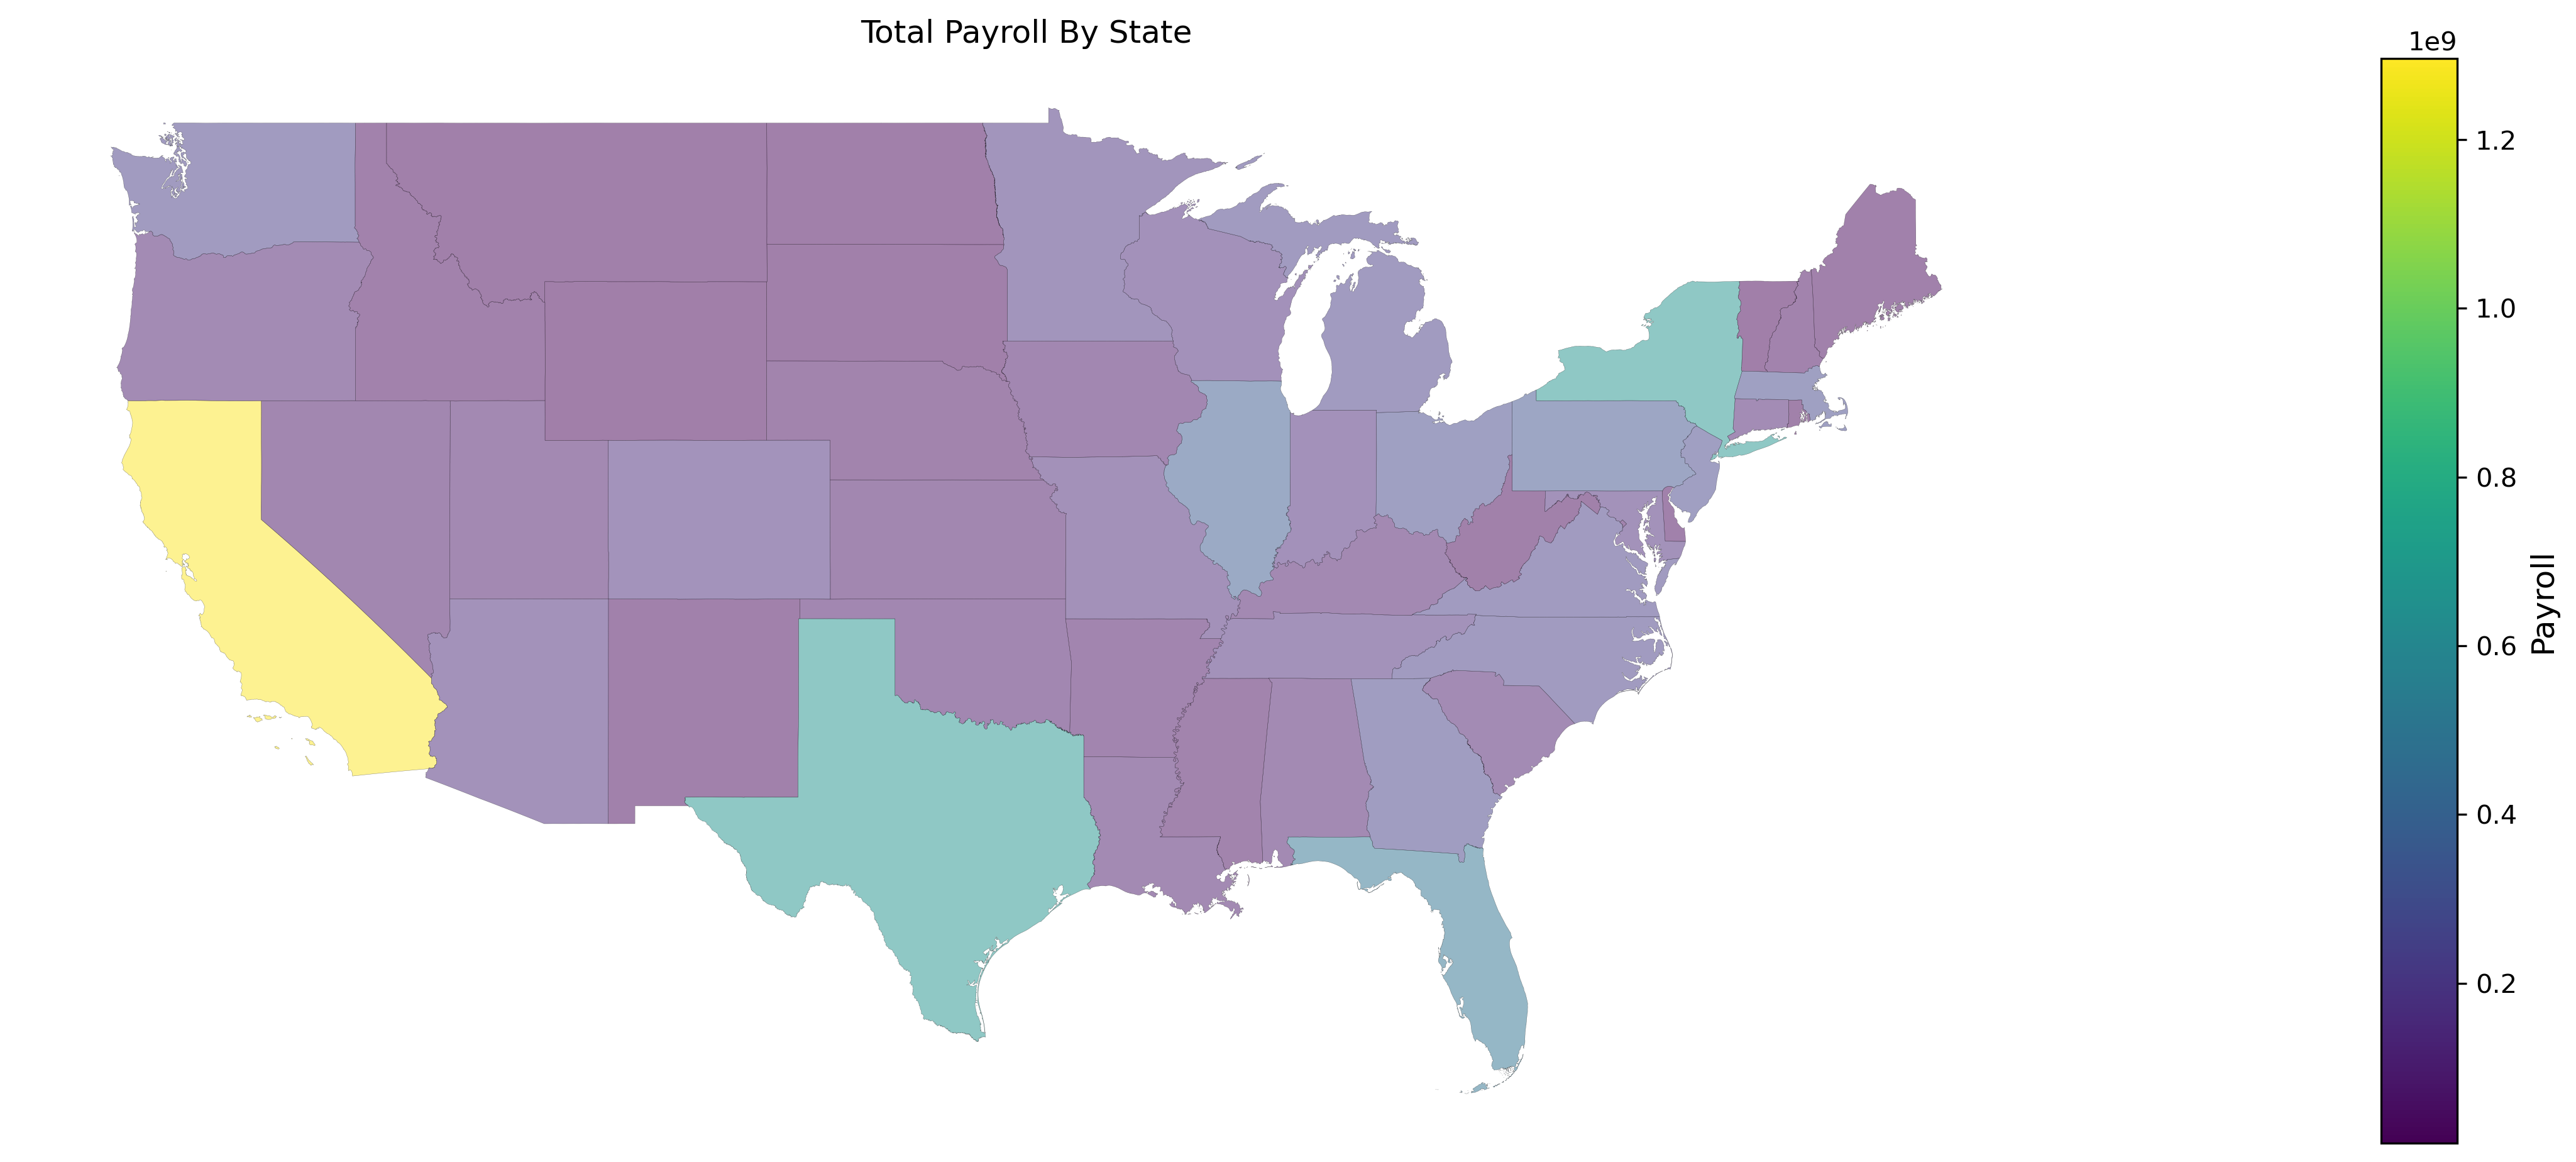

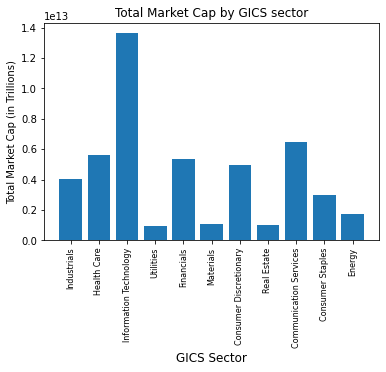

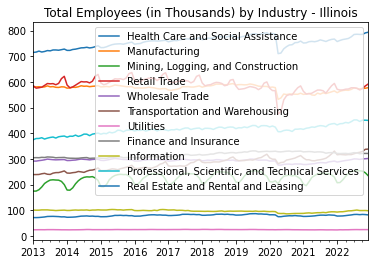

In [22]:
main()

### Summary

- California has a significantly higher payroll than any other state in the continental U.S.
- Information Technology was a stand out Global Industry Classification Sector for total market capitalization.
- The NAICS Health Care industry has remained the number one employer of working Illinois citizens since 2013. 